In [1]:
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

from utils import *
from sklearn import preprocessing
#use TF-IDF to transform bag-of-word counts into numerical features
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

In [2]:
data_icu = pd.read_csv('adult_icu.gz', compression='gzip')
data_notes = pd.read_csv('adult_notes.gz', compression='gzip')
# data_icu = pd.read_csv('csc2548_ml4h/adult_icu.gz', compression='gzip')
# data_notes = pd.read_csv('csc2548_ml4h/adult_notes.gz', compression='gzip')

In [3]:
# Extracting feature and splitting for adult_icu.gz
drop_cols = ['train', 'subject_id', 'hadm_id', 'icustay_id', 'mort_icu']
binary_cols = ['first_hosp_stay', 'first_icu_stay', 'adult_icu', 'eth_asian', 'eth_black', 'eth_hispanic', 'eth_other', 'eth_white', 'admType_ELECTIVE', 'admType_EMERGENCY', 'admType_NEWBORN', 'admType_URGENT']

In [4]:
for col in data_icu.columns:
        if ((col not in binary_cols) and (col not in drop_cols)):
            data_icu[col] = preprocessing.scale(data_icu[col])

In [5]:
# data_icu
X_train_icu = data_icu[data_icu['train'] == 1]
X_test_icu = data_icu[data_icu['train'] == 0]
y_train_icu = X_train_icu['mort_icu']
y_test_icu = X_test_icu['mort_icu']

X_train_icu = X_train_icu.drop(drop_cols, axis=1)
X_test_icu = X_test_icu.drop(drop_cols, axis=1)

In [6]:
# data_notes
drop_cols = ['train', 'subject_id', 'hadm_id', 'icustay_id', 'mort_icu']
# binary_cols = ['first_hosp_stay', 'first_icu_stay', 'adult_icu', 'eth_asi]
X_train_notes = data_notes[data_notes['train'] == 1]
X_test_notes = data_notes[data_notes['train'] == 0]
y_train_notes = X_train_notes['mort_icu']
y_test_notes = X_test_notes['mort_icu']

X_train_notes = X_train_notes.drop(drop_cols, axis=1)
X_test_notes = X_test_notes.drop(drop_cols, axis=1) 

In [7]:
tfidf_vectorizer = TfidfVectorizer()

In [8]:
X_train_notes = tfidf_vectorizer.fit_transform(X_train_notes['chartext'].values.astype('U'))
X_test_notes = tfidf_vectorizer.transform(X_test_notes['chartext'].values.astype('U'))

In [9]:
# combine two models togethor
from scipy.sparse import hstack

X_train = hstack([X_train_icu, X_train_notes])
X_test = hstack([X_test_icu, X_test_notes])

In [11]:
# logistic regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty = 'l2', max_iter=100)
clf.fit(X_train, y_train_icu)

/data/anaconda/envs/ml4h/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
from sklearn import metrics
y_predict = clf.predict(X_test)
y_predict_prob = clf.predict_proba(X_test)

# comment on model performance
print("Score on training set: ", clf.score(X_train,y_train_icu))
print("Score on testing set: ", clf.score(X_test,y_test_icu))
print("Accuracy score:",metrics.accuracy_score(y_test_icu, y_predict))
print("No. of iterations to converge: ", clf.n_iter_)

Score on training set:  0.9180302159025563
Score on testing set:  0.9111814089305268
Accuracy score: 0.9111814089305268
No. of iterations to converge:  [100]


In [13]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test_icu, y_predict_prob[:,1], pos_label = 1)

The threshod is:  [2.00000000e+00 1.00000000e+00 9.22858848e-01 ... 5.83523827e-03
 5.83334820e-03 6.39000260e-04]
AUC score:  0.8575662964472861


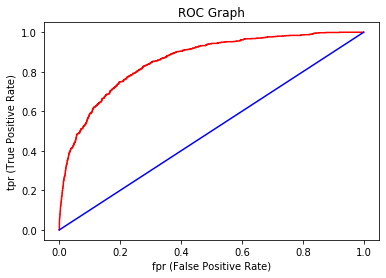

In [14]:
plot_roc(fpr, tpr,"4c_roc_graph.png")
print("The threshod is: ", thresholds)
print("AUC score: ", metrics.roc_auc_score(y_test_icu, y_predict_prob[:,1]))

In [15]:
risk_factors(list(X_train_icu.columns) + list(tfidf_vectorizer.get_feature_names()), clf.coef_)

------------------------------
Sort the value itself: 
Top 5 risk factors: 
2.231258674499076 icp
2.534415656282369 worsening
2.582782969036912 glucose_mean
3.2199268466864206 arrest
3.655053711738844 family
Lowest 5 risk factors: 
-2.2424700289038215 cabg
-2.097977441549197 extubation
-2.0235543310693096 wean
-1.8989294032354649 sepsis
-1.8909768890343137 trach
------------------------------
Sort using absolute value: 
Top 5 risk factors: 
2.2424700289038215 cabg
2.534415656282369 worsening
2.582782969036912 glucose_mean
3.2199268466864206 arrest
3.655053711738844 family
Lowest 5 risk factors: 
0.0 admType_NEWBORN
1.0715497620909016e-06 4sec
1.2259930200710172e-06 negligible
1.594405960994907e-06 varicosities
3.007196557574272e-06 precaution
